In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


In [4]:
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

In [5]:
df = pd.read_csv("AAPL.csv")
df.info()
df.head()
df.isna().sum()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9823 entries, 0 to 9822
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       9823 non-null   object 
 1   Open       9822 non-null   float64
 2   High       9822 non-null   float64
 3   Low        9822 non-null   float64
 4   Close      9822 non-null   float64
 5   Adj Close  9822 non-null   float64
 6   Volume     9822 non-null   float64
dtypes: float64(6), object(1)
memory usage: 537.3+ KB


Date         0
Open         1
High         1
Low          1
Close        1
Adj Close    1
Volume       1
dtype: int64

In [6]:
df = df.ffill()  # Forward fill


In [7]:
scaler = MinMaxScaler()
df['scaled_close'] = scaler.fit_transform(df[['Adj Close']])


In [8]:
def create_sequences(data, window_size, future_step=1):
    X, y = [], []
    for i in range(len(data) - window_size - future_step + 1):
        X.append(data[i:i+window_size])
        y.append(data[i+window_size+future_step-1])
    return np.array(X), np.array(y)

window_size = 45
X_1, y_1 = create_sequences(df['scaled_close'].values, window_size, future_step=1)
X_5, y_5 = create_sequences(df['scaled_close'].values, window_size, future_step=5)
X_10, y_10 = create_sequences(df['scaled_close'].values, window_size, future_step=10)


In [9]:
def train_test_split(X, y):
    split = int(0.8 * len(X))
    return X[:split], X[split:], y[:split], y[split:]

X1_train, X1_test, y1_train, y1_test = train_test_split(X_1, y_1)
X5_train, X5_test, y5_train, y5_test = train_test_split(X_5, y_5)
X10_train, X10_test, y10_train, y10_test = train_test_split(X_10, y_10)


In [10]:
def create_rnn_model(units=64, dropout=0.2, lr=0.001):
    model = Sequential([
        SimpleRNN(units, activation='tanh', input_shape=(window_size, 1)),
        Dropout(dropout),
        Dense(1)
    ])
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr), loss='mse')
    return model

def create_lstm_model(units=128, dropout=0.2, lr=0.001):
    model = Sequential([
        LSTM(units,activation='tanh', input_shape=(window_size, 1)),
        Dropout(dropout),
        Dense(1)
    ])
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr), loss='mse')
    return model


In [11]:
def train_and_evaluate(X_train, y_train, X_test, y_test, time_horizon):
    X_train = X_train.reshape(-1, window_size, 1)
    X_test = X_test.reshape(-1, window_size, 1)

    rnn = create_rnn_model()
    lstm = create_lstm_model()

    # Callbacks
    early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

    rnn_ckpt_path = f"rnn_best_model_{time_horizon}.keras"
    lstm_ckpt_path = f"lstm_best_model_{time_horizon}.keras"

    rnn_checkpoint = ModelCheckpoint(rnn_ckpt_path, save_best_only=True, monitor='val_loss')
    lstm_checkpoint = ModelCheckpoint(lstm_ckpt_path, save_best_only=True, monitor='val_loss')

    # Train RNN
    rnn.fit(
        X_train, y_train,
        epochs=100,
        batch_size=32,
        validation_split=0.1,
        callbacks=[early_stop, rnn_checkpoint],
        verbose=0
    )

    # Train LSTM
    lstm.fit(
        X_train, y_train,
        epochs=100,
        batch_size=32,
        validation_split=0.1,
        callbacks=[early_stop, lstm_checkpoint],
        verbose=0
    )

    # Load Best Weights
    rnn.load_weights(rnn_ckpt_path)
    lstm.load_weights(lstm_ckpt_path)

    # Predictions
    rnn_preds = rnn.predict(X_test)
    lstm_preds = lstm.predict(X_test)

    # Inverse Transform
    rnn_preds_inv = scaler.inverse_transform(rnn_preds)
    lstm_preds_inv = scaler.inverse_transform(lstm_preds)
    actual_inv = scaler.inverse_transform(y_test.reshape(-1, 1))

    # Evaluation
    rnn_mse = mean_squared_error(actual_inv, rnn_preds_inv)
    lstm_mse = mean_squared_error(actual_inv, lstm_preds_inv)
    rnn_rmse = np.sqrt(rnn_mse)
    lstm_rmse = np.sqrt(lstm_mse)

    print(f"{time_horizon}-Day Prediction RNN -> MSE: {rnn_mse:.2f}, RMSE: {rnn_rmse:.2f}")
    print(f"{time_horizon}-Day Prediction LSTM -> MSE: {lstm_mse:.2f}, RMSE: {lstm_rmse:.2f}")

    # Plotting
    plt.figure(figsize=(10, 5))
    plt.plot(actual_inv, label='Actual')
    plt.plot(rnn_preds_inv, label='RNN Predictions')
    plt.plot(lstm_preds_inv, label='LSTM Predictions')
    plt.title(f'{time_horizon}-Day Ahead Prediction')
    plt.legend()
    plt.show()


c:\Users\dakoj\.conda\envs\apple\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step
1-Day Prediction RNN -> MSE: 5.93, RMSE: 2.43
1-Day Prediction LSTM -> MSE: 8.32, RMSE: 2.88


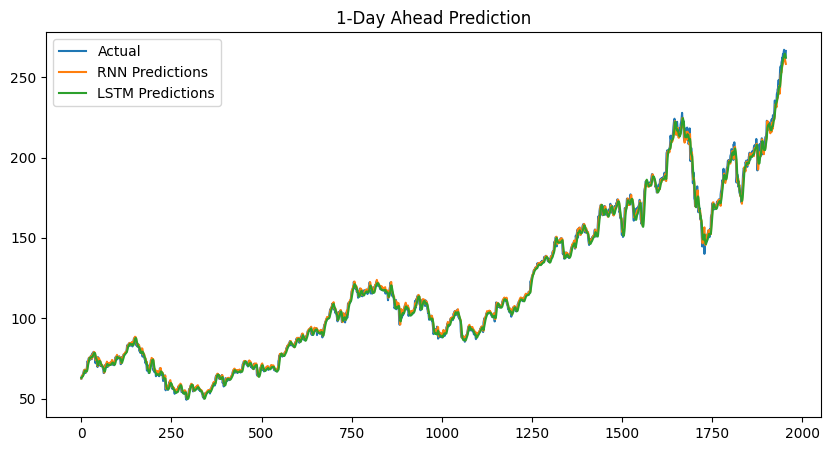

In [12]:
train_and_evaluate(X1_train, y1_train, X1_test, y1_test, time_horizon=1)



c:\Users\dakoj\.conda\envs\apple\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step
5-Day Prediction RNN -> MSE: 26.92, RMSE: 5.19
5-Day Prediction LSTM -> MSE: 23.93, RMSE: 4.89


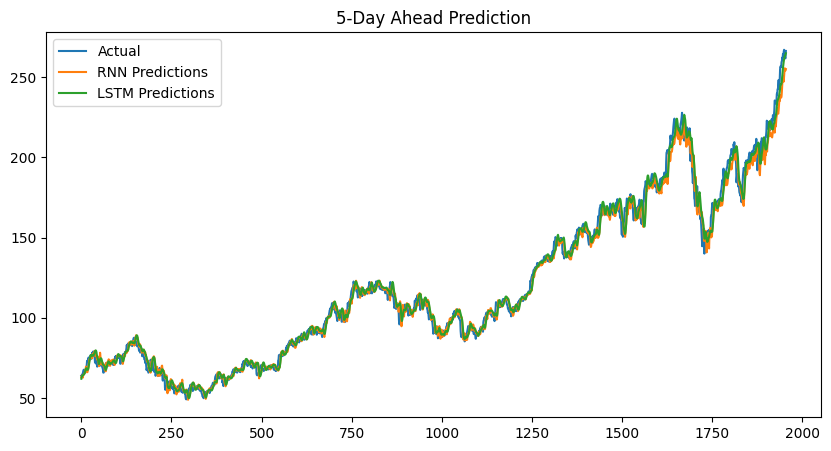

In [13]:
train_and_evaluate(X5_train, y5_train, X5_test, y5_test, time_horizon=5)

c:\Users\dakoj\.conda\envs\apple\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step
10-Day Prediction RNN -> MSE: 159.77, RMSE: 12.64
10-Day Prediction LSTM -> MSE: 199.48, RMSE: 14.12


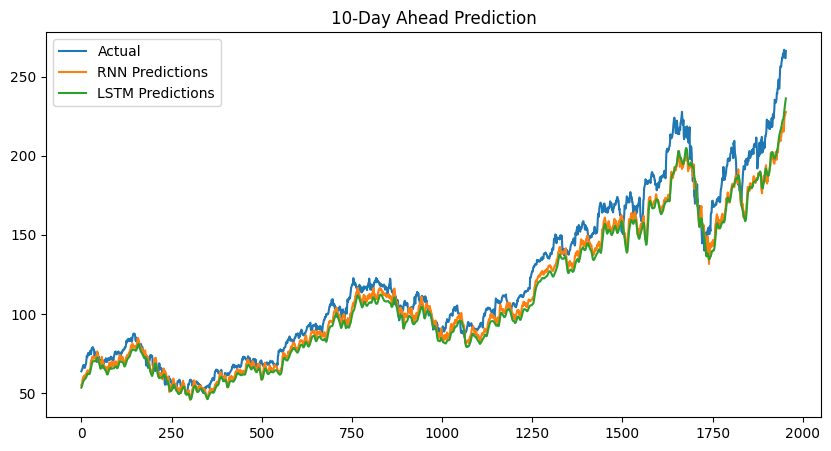

In [14]:
train_and_evaluate(X10_train, y10_train, X10_test, y10_test, time_horizon=10)

# LSTM Hyperparameter Tuning

In [15]:
def manual_lstm_tuning(X_train, y_train, window_size, name=""):
    X_train = X_train.reshape(-1, window_size, 1)

    # Simple train/val split
    split_idx = int(0.8 * len(X_train))
    X_tr, X_val = X_train[:split_idx], X_train[split_idx:]
    y_tr, y_val = y_train[:split_idx], y_train[split_idx:]

    # Hyperparameters to test
    units_list = [32, 50, 64, 128]
    dropout_list = [0.2, 0.3]
    lr_list = [0.001, 0.005]
    batch_size_list = [32]
    activation_list = ['relu', 'tanh', 'sigmoid']
    epochs = 100

    best_mse = float('inf')
    best_model = None
    best_params = {}

    for units in units_list:
        for dropout in dropout_list:
            for lr in lr_list:
                for batch_size in batch_size_list:
                    for func in activation_list:

                        print(f"\n🔄 {name} | Trying LSTM: activation Function = {func} units={units}, dropout={dropout}, lr={lr}")
                        model = Sequential([
                            LSTM(units, activation=func, input_shape=(window_size, 1)),
                            Dropout(dropout),
                            Dense(1)
                        ])
                        model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr), loss='mse')

                        early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
                        checkpoint = ModelCheckpoint(f"best_lstm_{name}.keras", monitor='val_loss', save_best_only=True)

                        model.fit(
                            X_tr, y_tr,
                            validation_data=(X_val, y_val),
                            epochs=epochs,
                            batch_size=batch_size,
                            callbacks=[early_stop, checkpoint],
                            verbose=0
                        )

                        val_preds = model.predict(X_val)
                        val_mse = mean_squared_error(y_val, val_preds)

                        if val_mse < best_mse:
                            best_mse = val_mse
                            best_model = model
                            best_params = {
                                'units': units,
                                'dropout': dropout,
                                'lr': lr,
                                'batch_size': batch_size
                            }
                            print(f"✅ New Best MSE for {name}: {val_mse:.4f} with {best_params}")
                        else:
                            print(f"✖ MSE: {val_mse:.4f}")

    return best_model, best_params, best_mse


In [16]:
# Run tuning
best_lstm_1d, best_params_1d, val_mse_1d = manual_lstm_tuning(X1_train, y1_train, window_size, name="1day")
best_lstm_5d, best_params_5d, val_mse_5d = manual_lstm_tuning(X5_train, y5_train, window_size, name="5day")
best_lstm_10d, best_params_10d, val_mse_10d = manual_lstm_tuning(X10_train, y10_train, window_size, name="10day")



🔄 1day | Trying LSTM: activation Function = relu units=32, dropout=0.2, lr=0.001


c:\Users\dakoj\.conda\envs\apple\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
✅ New Best MSE for 1day: 0.0006 with {'units': 32, 'dropout': 0.2, 'lr': 0.001, 'batch_size': 32}

🔄 1day | Trying LSTM: activation Function = tanh units=32, dropout=0.2, lr=0.001


c:\Users\dakoj\.conda\envs\apple\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
✅ New Best MSE for 1day: 0.0000 with {'units': 32, 'dropout': 0.2, 'lr': 0.001, 'batch_size': 32}

🔄 1day | Trying LSTM: activation Function = sigmoid units=32, dropout=0.2, lr=0.001


c:\Users\dakoj\.conda\envs\apple\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
✖ MSE: 0.0093

🔄 1day | Trying LSTM: activation Function = relu units=32, dropout=0.2, lr=0.005


c:\Users\dakoj\.conda\envs\apple\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
✖ MSE: 0.0001

🔄 1day | Trying LSTM: activation Function = tanh units=32, dropout=0.2, lr=0.005


c:\Users\dakoj\.conda\envs\apple\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
✅ New Best MSE for 1day: 0.0000 with {'units': 32, 'dropout': 0.2, 'lr': 0.005, 'batch_size': 32}

🔄 1day | Trying LSTM: activation Function = sigmoid units=32, dropout=0.2, lr=0.005


c:\Users\dakoj\.conda\envs\apple\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
✖ MSE: 0.0079

🔄 1day | Trying LSTM: activation Function = relu units=32, dropout=0.3, lr=0.001


c:\Users\dakoj\.conda\envs\apple\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
✖ MSE: 0.0001

🔄 1day | Trying LSTM: activation Function = tanh units=32, dropout=0.3, lr=0.001


c:\Users\dakoj\.conda\envs\apple\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
✖ MSE: 0.0000

🔄 1day | Trying LSTM: activation Function = sigmoid units=32, dropout=0.3, lr=0.001


c:\Users\dakoj\.conda\envs\apple\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
✖ MSE: 0.0079

🔄 1day | Trying LSTM: activation Function = relu units=32, dropout=0.3, lr=0.005


c:\Users\dakoj\.conda\envs\apple\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
✖ MSE: 0.0000

🔄 1day | Trying LSTM: activation Function = tanh units=32, dropout=0.3, lr=0.005


c:\Users\dakoj\.conda\envs\apple\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
✖ MSE: 0.0000

🔄 1day | Trying LSTM: activation Function = sigmoid units=32, dropout=0.3, lr=0.005


c:\Users\dakoj\.conda\envs\apple\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
✖ MSE: 0.0086

🔄 1day | Trying LSTM: activation Function = relu units=50, dropout=0.2, lr=0.001


c:\Users\dakoj\.conda\envs\apple\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
✖ MSE: 0.0000

🔄 1day | Trying LSTM: activation Function = tanh units=50, dropout=0.2, lr=0.001


c:\Users\dakoj\.conda\envs\apple\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
✖ MSE: 0.0000

🔄 1day | Trying LSTM: activation Function = sigmoid units=50, dropout=0.2, lr=0.001


c:\Users\dakoj\.conda\envs\apple\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
✖ MSE: 0.0074

🔄 1day | Trying LSTM: activation Function = relu units=50, dropout=0.2, lr=0.005


c:\Users\dakoj\.conda\envs\apple\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
✖ MSE: 0.0000

🔄 1day | Trying LSTM: activation Function = tanh units=50, dropout=0.2, lr=0.005


c:\Users\dakoj\.conda\envs\apple\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
✖ MSE: 0.0000

🔄 1day | Trying LSTM: activation Function = sigmoid units=50, dropout=0.2, lr=0.005


c:\Users\dakoj\.conda\envs\apple\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
✖ MSE: 0.0072

🔄 1day | Trying LSTM: activation Function = relu units=50, dropout=0.3, lr=0.001


c:\Users\dakoj\.conda\envs\apple\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
✖ MSE: 0.0000

🔄 1day | Trying LSTM: activation Function = tanh units=50, dropout=0.3, lr=0.001


c:\Users\dakoj\.conda\envs\apple\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
✖ MSE: 0.0000

🔄 1day | Trying LSTM: activation Function = sigmoid units=50, dropout=0.3, lr=0.001


c:\Users\dakoj\.conda\envs\apple\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
✖ MSE: 0.0088

🔄 1day | Trying LSTM: activation Function = relu units=50, dropout=0.3, lr=0.005


c:\Users\dakoj\.conda\envs\apple\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
✖ MSE: 0.0000

🔄 1day | Trying LSTM: activation Function = tanh units=50, dropout=0.3, lr=0.005


c:\Users\dakoj\.conda\envs\apple\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
✖ MSE: 0.0000

🔄 1day | Trying LSTM: activation Function = sigmoid units=50, dropout=0.3, lr=0.005


c:\Users\dakoj\.conda\envs\apple\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
✖ MSE: 0.0083

🔄 1day | Trying LSTM: activation Function = relu units=64, dropout=0.2, lr=0.001


c:\Users\dakoj\.conda\envs\apple\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
✖ MSE: 0.0000

🔄 1day | Trying LSTM: activation Function = tanh units=64, dropout=0.2, lr=0.001


c:\Users\dakoj\.conda\envs\apple\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
✖ MSE: 0.0000

🔄 1day | Trying LSTM: activation Function = sigmoid units=64, dropout=0.2, lr=0.001


c:\Users\dakoj\.conda\envs\apple\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
✖ MSE: 0.0049

🔄 1day | Trying LSTM: activation Function = relu units=64, dropout=0.2, lr=0.005


c:\Users\dakoj\.conda\envs\apple\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
✖ MSE: 0.0000

🔄 1day | Trying LSTM: activation Function = tanh units=64, dropout=0.2, lr=0.005


c:\Users\dakoj\.conda\envs\apple\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
✅ New Best MSE for 1day: 0.0000 with {'units': 64, 'dropout': 0.2, 'lr': 0.005, 'batch_size': 32}

🔄 1day | Trying LSTM: activation Function = sigmoid units=64, dropout=0.2, lr=0.005


c:\Users\dakoj\.conda\envs\apple\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
✖ MSE: 0.0059

🔄 1day | Trying LSTM: activation Function = relu units=64, dropout=0.3, lr=0.001


c:\Users\dakoj\.conda\envs\apple\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
✖ MSE: 0.0000

🔄 1day | Trying LSTM: activation Function = tanh units=64, dropout=0.3, lr=0.001


c:\Users\dakoj\.conda\envs\apple\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
✖ MSE: 0.0000

🔄 1day | Trying LSTM: activation Function = sigmoid units=64, dropout=0.3, lr=0.001


c:\Users\dakoj\.conda\envs\apple\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
✖ MSE: 0.0071

🔄 1day | Trying LSTM: activation Function = relu units=64, dropout=0.3, lr=0.005


c:\Users\dakoj\.conda\envs\apple\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
✖ MSE: 0.0000

🔄 1day | Trying LSTM: activation Function = tanh units=64, dropout=0.3, lr=0.005


c:\Users\dakoj\.conda\envs\apple\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
✖ MSE: 0.0000

🔄 1day | Trying LSTM: activation Function = sigmoid units=64, dropout=0.3, lr=0.005


c:\Users\dakoj\.conda\envs\apple\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
✖ MSE: 0.0083

🔄 1day | Trying LSTM: activation Function = relu units=128, dropout=0.2, lr=0.001


c:\Users\dakoj\.conda\envs\apple\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step
✖ MSE: 0.0000

🔄 1day | Trying LSTM: activation Function = tanh units=128, dropout=0.2, lr=0.001


c:\Users\dakoj\.conda\envs\apple\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step
✖ MSE: 0.0000

🔄 1day | Trying LSTM: activation Function = sigmoid units=128, dropout=0.2, lr=0.001


c:\Users\dakoj\.conda\envs\apple\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step
✖ MSE: 0.0062

🔄 1day | Trying LSTM: activation Function = relu units=128, dropout=0.2, lr=0.005


c:\Users\dakoj\.conda\envs\apple\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step
✖ MSE: 0.0000

🔄 1day | Trying LSTM: activation Function = tanh units=128, dropout=0.2, lr=0.005


c:\Users\dakoj\.conda\envs\apple\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step
✖ MSE: 0.0000

🔄 1day | Trying LSTM: activation Function = sigmoid units=128, dropout=0.2, lr=0.005


c:\Users\dakoj\.conda\envs\apple\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step
✖ MSE: 0.0072

🔄 1day | Trying LSTM: activation Function = relu units=128, dropout=0.3, lr=0.001


c:\Users\dakoj\.conda\envs\apple\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step
✖ MSE: 0.0000

🔄 1day | Trying LSTM: activation Function = tanh units=128, dropout=0.3, lr=0.001


c:\Users\dakoj\.conda\envs\apple\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step
✖ MSE: 0.0000

🔄 1day | Trying LSTM: activation Function = sigmoid units=128, dropout=0.3, lr=0.001


c:\Users\dakoj\.conda\envs\apple\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step
✖ MSE: 0.0059

🔄 1day | Trying LSTM: activation Function = relu units=128, dropout=0.3, lr=0.005


c:\Users\dakoj\.conda\envs\apple\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step
✖ MSE: 0.0000

🔄 1day | Trying LSTM: activation Function = tanh units=128, dropout=0.3, lr=0.005


c:\Users\dakoj\.conda\envs\apple\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step
✖ MSE: 0.0000

🔄 1day | Trying LSTM: activation Function = sigmoid units=128, dropout=0.3, lr=0.005


c:\Users\dakoj\.conda\envs\apple\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step
✖ MSE: 0.0078

🔄 5day | Trying LSTM: activation Function = relu units=32, dropout=0.2, lr=0.001


c:\Users\dakoj\.conda\envs\apple\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
✅ New Best MSE for 5day: 0.0000 with {'units': 32, 'dropout': 0.2, 'lr': 0.001, 'batch_size': 32}

🔄 5day | Trying LSTM: activation Function = tanh units=32, dropout=0.2, lr=0.001


c:\Users\dakoj\.conda\envs\apple\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
✅ New Best MSE for 5day: 0.0000 with {'units': 32, 'dropout': 0.2, 'lr': 0.001, 'batch_size': 32}

🔄 5day | Trying LSTM: activation Function = sigmoid units=32, dropout=0.2, lr=0.001


c:\Users\dakoj\.conda\envs\apple\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
✖ MSE: 0.0088

🔄 5day | Trying LSTM: activation Function = relu units=32, dropout=0.2, lr=0.005


c:\Users\dakoj\.conda\envs\apple\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
✖ MSE: 0.0000

🔄 5day | Trying LSTM: activation Function = tanh units=32, dropout=0.2, lr=0.005


c:\Users\dakoj\.conda\envs\apple\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
✅ New Best MSE for 5day: 0.0000 with {'units': 32, 'dropout': 0.2, 'lr': 0.005, 'batch_size': 32}

🔄 5day | Trying LSTM: activation Function = sigmoid units=32, dropout=0.2, lr=0.005


c:\Users\dakoj\.conda\envs\apple\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
✖ MSE: 0.0078

🔄 5day | Trying LSTM: activation Function = relu units=32, dropout=0.3, lr=0.001


c:\Users\dakoj\.conda\envs\apple\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
✖ MSE: 0.0001

🔄 5day | Trying LSTM: activation Function = tanh units=32, dropout=0.3, lr=0.001


c:\Users\dakoj\.conda\envs\apple\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
✖ MSE: 0.0000

🔄 5day | Trying LSTM: activation Function = sigmoid units=32, dropout=0.3, lr=0.001


c:\Users\dakoj\.conda\envs\apple\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
✖ MSE: 0.0093

🔄 5day | Trying LSTM: activation Function = relu units=32, dropout=0.3, lr=0.005


c:\Users\dakoj\.conda\envs\apple\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
✖ MSE: 0.0000

🔄 5day | Trying LSTM: activation Function = tanh units=32, dropout=0.3, lr=0.005


c:\Users\dakoj\.conda\envs\apple\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
✖ MSE: 0.0000

🔄 5day | Trying LSTM: activation Function = sigmoid units=32, dropout=0.3, lr=0.005


c:\Users\dakoj\.conda\envs\apple\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
✖ MSE: 0.0087

🔄 5day | Trying LSTM: activation Function = relu units=50, dropout=0.2, lr=0.001


c:\Users\dakoj\.conda\envs\apple\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
✖ MSE: 0.0000

🔄 5day | Trying LSTM: activation Function = tanh units=50, dropout=0.2, lr=0.001


c:\Users\dakoj\.conda\envs\apple\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
✖ MSE: 0.0000

🔄 5day | Trying LSTM: activation Function = sigmoid units=50, dropout=0.2, lr=0.001


c:\Users\dakoj\.conda\envs\apple\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
✖ MSE: 0.0087

🔄 5day | Trying LSTM: activation Function = relu units=50, dropout=0.2, lr=0.005


c:\Users\dakoj\.conda\envs\apple\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
✖ MSE: 0.0001

🔄 5day | Trying LSTM: activation Function = tanh units=50, dropout=0.2, lr=0.005


c:\Users\dakoj\.conda\envs\apple\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
✖ MSE: 0.0000

🔄 5day | Trying LSTM: activation Function = sigmoid units=50, dropout=0.2, lr=0.005


c:\Users\dakoj\.conda\envs\apple\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
✖ MSE: 0.0065

🔄 5day | Trying LSTM: activation Function = relu units=50, dropout=0.3, lr=0.001


c:\Users\dakoj\.conda\envs\apple\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
✖ MSE: 0.0000

🔄 5day | Trying LSTM: activation Function = tanh units=50, dropout=0.3, lr=0.001


c:\Users\dakoj\.conda\envs\apple\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
✖ MSE: 0.0000

🔄 5day | Trying LSTM: activation Function = sigmoid units=50, dropout=0.3, lr=0.001


c:\Users\dakoj\.conda\envs\apple\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
✖ MSE: 0.0082

🔄 5day | Trying LSTM: activation Function = relu units=50, dropout=0.3, lr=0.005


c:\Users\dakoj\.conda\envs\apple\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
✖ MSE: 0.0000

🔄 5day | Trying LSTM: activation Function = tanh units=50, dropout=0.3, lr=0.005


c:\Users\dakoj\.conda\envs\apple\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
✖ MSE: 0.0000

🔄 5day | Trying LSTM: activation Function = sigmoid units=50, dropout=0.3, lr=0.005


c:\Users\dakoj\.conda\envs\apple\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
✖ MSE: 0.0078

🔄 5day | Trying LSTM: activation Function = relu units=64, dropout=0.2, lr=0.001


c:\Users\dakoj\.conda\envs\apple\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
✖ MSE: 0.0000

🔄 5day | Trying LSTM: activation Function = tanh units=64, dropout=0.2, lr=0.001


c:\Users\dakoj\.conda\envs\apple\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
✖ MSE: 0.0000

🔄 5day | Trying LSTM: activation Function = sigmoid units=64, dropout=0.2, lr=0.001


c:\Users\dakoj\.conda\envs\apple\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
✖ MSE: 0.0070

🔄 5day | Trying LSTM: activation Function = relu units=64, dropout=0.2, lr=0.005


c:\Users\dakoj\.conda\envs\apple\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
✖ MSE: 0.0000

🔄 5day | Trying LSTM: activation Function = tanh units=64, dropout=0.2, lr=0.005


c:\Users\dakoj\.conda\envs\apple\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
✖ MSE: 0.0000

🔄 5day | Trying LSTM: activation Function = sigmoid units=64, dropout=0.2, lr=0.005


c:\Users\dakoj\.conda\envs\apple\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
✖ MSE: 0.0084

🔄 5day | Trying LSTM: activation Function = relu units=64, dropout=0.3, lr=0.001


c:\Users\dakoj\.conda\envs\apple\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
✖ MSE: 0.0000

🔄 5day | Trying LSTM: activation Function = tanh units=64, dropout=0.3, lr=0.001


c:\Users\dakoj\.conda\envs\apple\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
✖ MSE: 0.0000

🔄 5day | Trying LSTM: activation Function = sigmoid units=64, dropout=0.3, lr=0.001


c:\Users\dakoj\.conda\envs\apple\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
✖ MSE: 0.0057

🔄 5day | Trying LSTM: activation Function = relu units=64, dropout=0.3, lr=0.005


c:\Users\dakoj\.conda\envs\apple\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
✖ MSE: 0.0000

🔄 5day | Trying LSTM: activation Function = tanh units=64, dropout=0.3, lr=0.005


c:\Users\dakoj\.conda\envs\apple\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
✖ MSE: 0.0000

🔄 5day | Trying LSTM: activation Function = sigmoid units=64, dropout=0.3, lr=0.005


c:\Users\dakoj\.conda\envs\apple\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
✖ MSE: 0.0083

🔄 5day | Trying LSTM: activation Function = relu units=128, dropout=0.2, lr=0.001


c:\Users\dakoj\.conda\envs\apple\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step
✖ MSE: 0.0000

🔄 5day | Trying LSTM: activation Function = tanh units=128, dropout=0.2, lr=0.001


c:\Users\dakoj\.conda\envs\apple\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step
✖ MSE: 0.0000

🔄 5day | Trying LSTM: activation Function = sigmoid units=128, dropout=0.2, lr=0.001


c:\Users\dakoj\.conda\envs\apple\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step
✖ MSE: 0.0087

🔄 5day | Trying LSTM: activation Function = relu units=128, dropout=0.2, lr=0.005


c:\Users\dakoj\.conda\envs\apple\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step
✖ MSE: 0.0000

🔄 5day | Trying LSTM: activation Function = tanh units=128, dropout=0.2, lr=0.005


c:\Users\dakoj\.conda\envs\apple\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step
✖ MSE: 0.0000

🔄 5day | Trying LSTM: activation Function = sigmoid units=128, dropout=0.2, lr=0.005


c:\Users\dakoj\.conda\envs\apple\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step
✖ MSE: 0.0075

🔄 5day | Trying LSTM: activation Function = relu units=128, dropout=0.3, lr=0.001


c:\Users\dakoj\.conda\envs\apple\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step
✖ MSE: 0.0000

🔄 5day | Trying LSTM: activation Function = tanh units=128, dropout=0.3, lr=0.001


c:\Users\dakoj\.conda\envs\apple\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step
✖ MSE: 0.0000

🔄 5day | Trying LSTM: activation Function = sigmoid units=128, dropout=0.3, lr=0.001


c:\Users\dakoj\.conda\envs\apple\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step
✖ MSE: 0.0051

🔄 5day | Trying LSTM: activation Function = relu units=128, dropout=0.3, lr=0.005


c:\Users\dakoj\.conda\envs\apple\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step
✖ MSE: 0.0000

🔄 5day | Trying LSTM: activation Function = tanh units=128, dropout=0.3, lr=0.005


c:\Users\dakoj\.conda\envs\apple\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step
✖ MSE: 0.0000

🔄 5day | Trying LSTM: activation Function = sigmoid units=128, dropout=0.3, lr=0.005


c:\Users\dakoj\.conda\envs\apple\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step
✖ MSE: 0.0069

🔄 10day | Trying LSTM: activation Function = relu units=32, dropout=0.2, lr=0.001


c:\Users\dakoj\.conda\envs\apple\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
✅ New Best MSE for 10day: 0.0001 with {'units': 32, 'dropout': 0.2, 'lr': 0.001, 'batch_size': 32}

🔄 10day | Trying LSTM: activation Function = tanh units=32, dropout=0.2, lr=0.001


c:\Users\dakoj\.conda\envs\apple\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
✅ New Best MSE for 10day: 0.0000 with {'units': 32, 'dropout': 0.2, 'lr': 0.001, 'batch_size': 32}

🔄 10day | Trying LSTM: activation Function = sigmoid units=32, dropout=0.2, lr=0.001


c:\Users\dakoj\.conda\envs\apple\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
✖ MSE: 0.0079

🔄 10day | Trying LSTM: activation Function = relu units=32, dropout=0.2, lr=0.005


c:\Users\dakoj\.conda\envs\apple\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
✖ MSE: 0.0001

🔄 10day | Trying LSTM: activation Function = tanh units=32, dropout=0.2, lr=0.005


c:\Users\dakoj\.conda\envs\apple\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
✖ MSE: 0.0000

🔄 10day | Trying LSTM: activation Function = sigmoid units=32, dropout=0.2, lr=0.005


c:\Users\dakoj\.conda\envs\apple\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
✖ MSE: 0.0074

🔄 10day | Trying LSTM: activation Function = relu units=32, dropout=0.3, lr=0.001


c:\Users\dakoj\.conda\envs\apple\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
✖ MSE: 0.0004

🔄 10day | Trying LSTM: activation Function = tanh units=32, dropout=0.3, lr=0.001


c:\Users\dakoj\.conda\envs\apple\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
✖ MSE: 0.0000

🔄 10day | Trying LSTM: activation Function = sigmoid units=32, dropout=0.3, lr=0.001


c:\Users\dakoj\.conda\envs\apple\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
✖ MSE: 0.0062

🔄 10day | Trying LSTM: activation Function = relu units=32, dropout=0.3, lr=0.005


c:\Users\dakoj\.conda\envs\apple\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
✖ MSE: 0.0001

🔄 10day | Trying LSTM: activation Function = tanh units=32, dropout=0.3, lr=0.005


c:\Users\dakoj\.conda\envs\apple\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
✖ MSE: 0.0000

🔄 10day | Trying LSTM: activation Function = sigmoid units=32, dropout=0.3, lr=0.005


c:\Users\dakoj\.conda\envs\apple\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
✖ MSE: 0.0084

🔄 10day | Trying LSTM: activation Function = relu units=50, dropout=0.2, lr=0.001


c:\Users\dakoj\.conda\envs\apple\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
✖ MSE: 0.0000

🔄 10day | Trying LSTM: activation Function = tanh units=50, dropout=0.2, lr=0.001


c:\Users\dakoj\.conda\envs\apple\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
✖ MSE: 0.0000

🔄 10day | Trying LSTM: activation Function = sigmoid units=50, dropout=0.2, lr=0.001


c:\Users\dakoj\.conda\envs\apple\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
✖ MSE: 0.0055

🔄 10day | Trying LSTM: activation Function = relu units=50, dropout=0.2, lr=0.005


c:\Users\dakoj\.conda\envs\apple\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
✖ MSE: 0.0000

🔄 10day | Trying LSTM: activation Function = tanh units=50, dropout=0.2, lr=0.005


c:\Users\dakoj\.conda\envs\apple\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
✅ New Best MSE for 10day: 0.0000 with {'units': 50, 'dropout': 0.2, 'lr': 0.005, 'batch_size': 32}

🔄 10day | Trying LSTM: activation Function = sigmoid units=50, dropout=0.2, lr=0.005


c:\Users\dakoj\.conda\envs\apple\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
✖ MSE: 0.0078

🔄 10day | Trying LSTM: activation Function = relu units=50, dropout=0.3, lr=0.001


c:\Users\dakoj\.conda\envs\apple\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
✖ MSE: 0.0001

🔄 10day | Trying LSTM: activation Function = tanh units=50, dropout=0.3, lr=0.001


c:\Users\dakoj\.conda\envs\apple\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
✖ MSE: 0.0000

🔄 10day | Trying LSTM: activation Function = sigmoid units=50, dropout=0.3, lr=0.001


c:\Users\dakoj\.conda\envs\apple\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
✖ MSE: 0.0093

🔄 10day | Trying LSTM: activation Function = relu units=50, dropout=0.3, lr=0.005


c:\Users\dakoj\.conda\envs\apple\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
✖ MSE: 0.0001

🔄 10day | Trying LSTM: activation Function = tanh units=50, dropout=0.3, lr=0.005


c:\Users\dakoj\.conda\envs\apple\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
✖ MSE: 0.0000

🔄 10day | Trying LSTM: activation Function = sigmoid units=50, dropout=0.3, lr=0.005


c:\Users\dakoj\.conda\envs\apple\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
✖ MSE: 0.0084

🔄 10day | Trying LSTM: activation Function = relu units=64, dropout=0.2, lr=0.001


c:\Users\dakoj\.conda\envs\apple\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
✖ MSE: 0.0000

🔄 10day | Trying LSTM: activation Function = tanh units=64, dropout=0.2, lr=0.001


c:\Users\dakoj\.conda\envs\apple\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
✖ MSE: 0.0000

🔄 10day | Trying LSTM: activation Function = sigmoid units=64, dropout=0.2, lr=0.001


c:\Users\dakoj\.conda\envs\apple\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step
✖ MSE: 0.0082

🔄 10day | Trying LSTM: activation Function = relu units=64, dropout=0.2, lr=0.005


c:\Users\dakoj\.conda\envs\apple\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
✖ MSE: 0.0000

🔄 10day | Trying LSTM: activation Function = tanh units=64, dropout=0.2, lr=0.005


c:\Users\dakoj\.conda\envs\apple\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
✖ MSE: 0.0000

🔄 10day | Trying LSTM: activation Function = sigmoid units=64, dropout=0.2, lr=0.005


c:\Users\dakoj\.conda\envs\apple\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
✖ MSE: 0.0077

🔄 10day | Trying LSTM: activation Function = relu units=64, dropout=0.3, lr=0.001


c:\Users\dakoj\.conda\envs\apple\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
✖ MSE: 0.0001

🔄 10day | Trying LSTM: activation Function = tanh units=64, dropout=0.3, lr=0.001


c:\Users\dakoj\.conda\envs\apple\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
✖ MSE: 0.0000

🔄 10day | Trying LSTM: activation Function = sigmoid units=64, dropout=0.3, lr=0.001


c:\Users\dakoj\.conda\envs\apple\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
✖ MSE: 0.0094

🔄 10day | Trying LSTM: activation Function = relu units=64, dropout=0.3, lr=0.005


c:\Users\dakoj\.conda\envs\apple\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step
✖ MSE: 0.0001

🔄 10day | Trying LSTM: activation Function = tanh units=64, dropout=0.3, lr=0.005


c:\Users\dakoj\.conda\envs\apple\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
✖ MSE: 0.0000

🔄 10day | Trying LSTM: activation Function = sigmoid units=64, dropout=0.3, lr=0.005


c:\Users\dakoj\.conda\envs\apple\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
✖ MSE: 0.0074

🔄 10day | Trying LSTM: activation Function = relu units=128, dropout=0.2, lr=0.001


c:\Users\dakoj\.conda\envs\apple\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step
✖ MSE: 0.0001

🔄 10day | Trying LSTM: activation Function = tanh units=128, dropout=0.2, lr=0.001


c:\Users\dakoj\.conda\envs\apple\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step
✖ MSE: 0.0000

🔄 10day | Trying LSTM: activation Function = sigmoid units=128, dropout=0.2, lr=0.001


c:\Users\dakoj\.conda\envs\apple\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step
✖ MSE: 0.0077

🔄 10day | Trying LSTM: activation Function = relu units=128, dropout=0.2, lr=0.005


c:\Users\dakoj\.conda\envs\apple\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step
✖ MSE: 0.0001

🔄 10day | Trying LSTM: activation Function = tanh units=128, dropout=0.2, lr=0.005


c:\Users\dakoj\.conda\envs\apple\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step
✖ MSE: 0.0000

🔄 10day | Trying LSTM: activation Function = sigmoid units=128, dropout=0.2, lr=0.005


c:\Users\dakoj\.conda\envs\apple\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step
✖ MSE: 0.0086

🔄 10day | Trying LSTM: activation Function = relu units=128, dropout=0.3, lr=0.001


c:\Users\dakoj\.conda\envs\apple\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step
✖ MSE: 0.0001

🔄 10day | Trying LSTM: activation Function = tanh units=128, dropout=0.3, lr=0.001


c:\Users\dakoj\.conda\envs\apple\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step
✖ MSE: 0.0000

🔄 10day | Trying LSTM: activation Function = sigmoid units=128, dropout=0.3, lr=0.001


c:\Users\dakoj\.conda\envs\apple\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step
✖ MSE: 0.0075

🔄 10day | Trying LSTM: activation Function = relu units=128, dropout=0.3, lr=0.005


c:\Users\dakoj\.conda\envs\apple\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step
✖ MSE: 0.0000

🔄 10day | Trying LSTM: activation Function = tanh units=128, dropout=0.3, lr=0.005


c:\Users\dakoj\.conda\envs\apple\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step
✖ MSE: 0.0000

🔄 10day | Trying LSTM: activation Function = sigmoid units=128, dropout=0.3, lr=0.005


c:\Users\dakoj\.conda\envs\apple\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step
✖ MSE: 0.0086


In [22]:
def evaluate_lstm(model, X_test, y_test, scaler, window_size, name=""):
    X_test = X_test.reshape(-1, window_size, 1)
    predictions = model.predict(X_test)
    predictions = scaler.inverse_transform(predictions)
    actual = scaler.inverse_transform(y_test.reshape(-1, 1))

    mse = mean_squared_error(actual, predictions)
    rmse = np.sqrt(mse)

    print(f"\n📊 {name} Prediction:")
    print(f"Test MSE: {mse:.2f}")
    print(f"Test RMSE: {rmse:.2f}")

    plt.figure(figsize=(10, 5))
    plt.plot(actual, label='Actual')
    plt.plot(predictions, label='LSTM Predictions')
    plt.title(f'{name} Prediction')
    plt.legend()
    plt.show()

    return mse, rmse


62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step

📊 1-Day Prediction:
Test MSE: 14.66
Test RMSE: 3.83


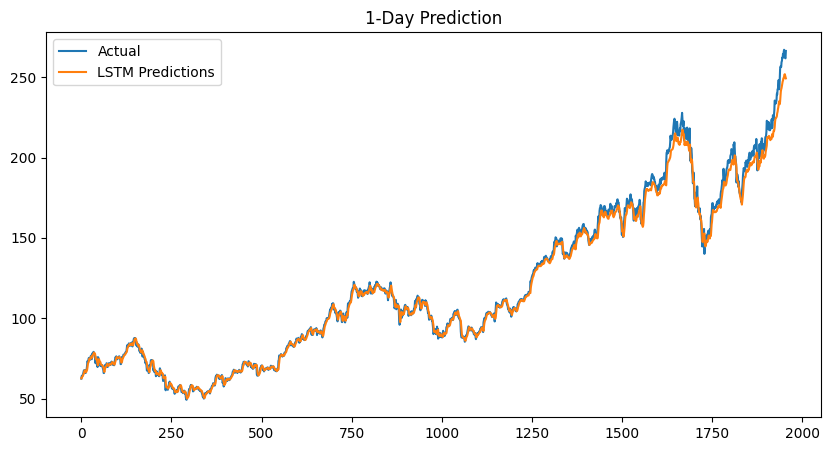

62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step

📊 5-Day Prediction:
Test MSE: 24.08
Test RMSE: 4.91


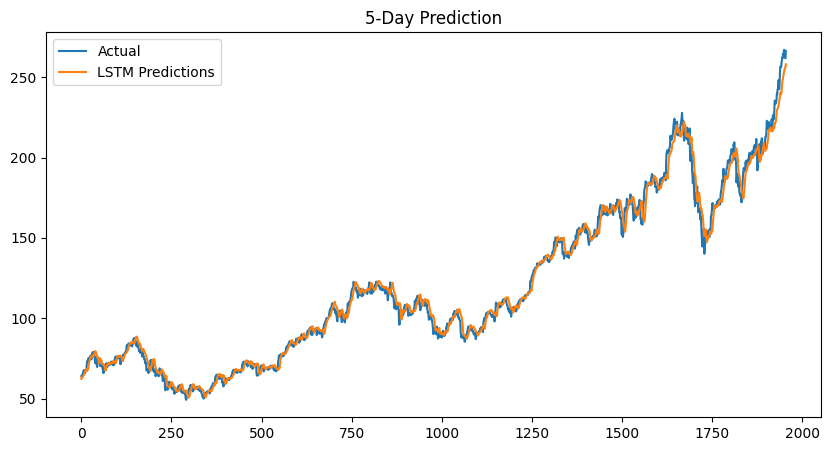

62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step

📊 10-Day Prediction:
Test MSE: 60.50
Test RMSE: 7.78


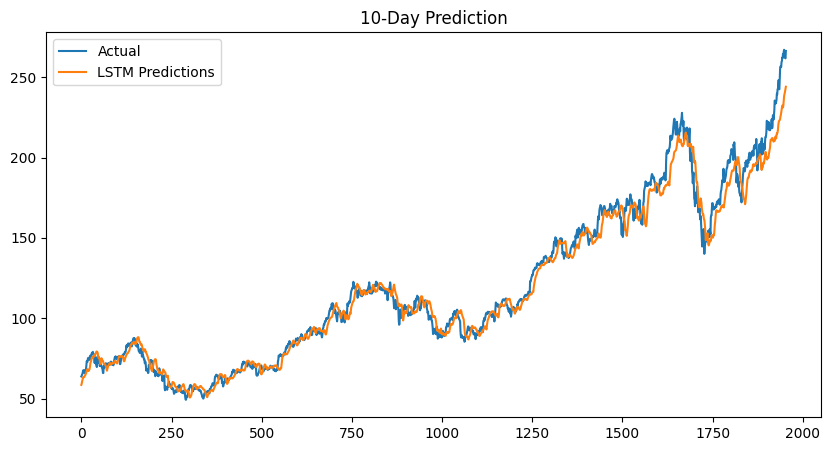

(60.50102718570924, np.float64(7.778240622769987))

In [23]:
# Evaluate all models
evaluate_lstm(best_lstm_1d, X1_test, y1_test, scaler, window_size, name="1-Day")
evaluate_lstm(best_lstm_5d, X5_test, y5_test, scaler, window_size, name="5-Day")
evaluate_lstm(best_lstm_10d, X10_test, y10_test, scaler, window_size, name="10-Day")
